## 9. Diffusion - Conditioning and Guidance

- Making significant use of the excellent `smalldiffusion` library: https://github.com/yuanchenyang/smalldiffusion

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise
from pathlib import Path
from tqdm import tqdm

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [2]:
torch_seed=2
N_sample=256 
sigma_max=1

In [3]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=3)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

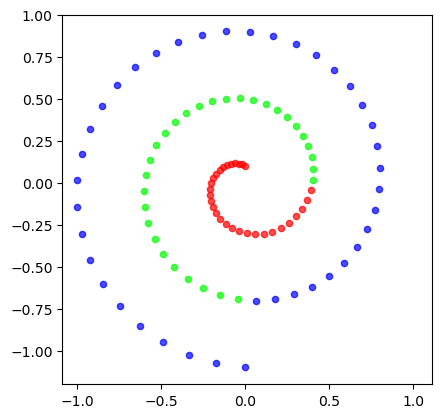

In [4]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
plt.axis('square');

In [5]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|████████████████████████| 30000/30000 [04:39<00:00, 107.28it/s]


In [6]:
bound=2.0
num_heatmap_steps=64
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

### Conditioning only, no guidance

In [7]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

torch.manual_seed(torch_seed)
sample_batch_size=128
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
unconditioned_heatmaps=[]
conditioned_heatmaps=[]

for c in range(dataset.num_classes):
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    unconditioned_heatmaps.append([])
    conditioned_heatmaps.append([])
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) 
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

            uncond = torch.full_like(cond_grid.to('cuda'), model.cond_embed.null_cond) # (B,)
            eps_cond, eps_uncond = model.predict_eps(                  # (B,), (B,)
                torch.cat([grid.to('cuda'), grid.to('cuda')]), sig.to(xt), torch.cat([cond_grid.to('cuda'), uncond])  
            ).chunk(2)
            unconditioned_heatmaps[-1].append(eps_uncond.cpu())
            conditioned_heatmaps[-1].append(eps_cond.cpu())
    
    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())
xt_history=np.array(xt_history)
heatmaps=np.array(heatmaps)

(-1.1, 1.1)

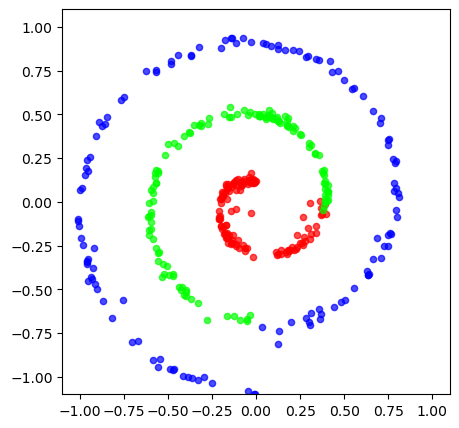

In [8]:
plt.figure(0, (5,5))
for class_idx in range(dataset.num_classes):
    plt.scatter(results_by_class[class_idx][:, 0], results_by_class[class_idx][:, 1], 
               c=[colors[class_idx]], alpha=0.7, s=20)
plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

### Guidance

In [9]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

torch.manual_seed(torch_seed)
sample_batch_size=128
gam=1.0
cfg_scale=1.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
unconditioned_heatmaps=[]
conditioned_heatmaps=[]

for c in range(dataset.num_classes):
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    unconditioned_heatmaps.append([])
    conditioned_heatmaps.append([])
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) 
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())
            uncond = torch.full_like(cond_grid.to('cuda'), model.cond_embed.null_cond) # (B,)
            eps_cond, eps_uncond = model.predict_eps(                  # (B,), (B,)
                torch.cat([grid.to('cuda'), grid.to('cuda')]), sig.to(xt), torch.cat([cond_grid.to('cuda'), uncond]) 
            ).chunk(2)
            unconditioned_heatmaps[-1].append(eps_uncond.cpu())
            conditioned_heatmaps[-1].append(eps_cond.cpu())
    
    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())
xt_history=np.array(xt_history)
heatmaps=np.array(heatmaps)

(-1.1, 1.1)

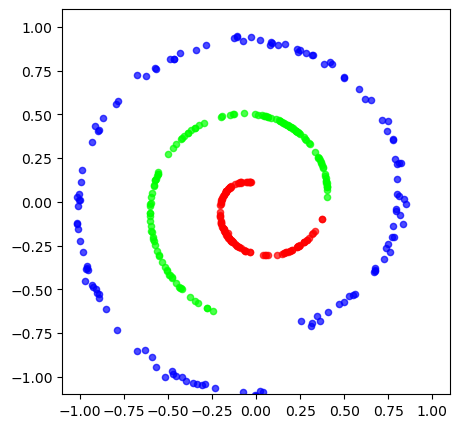

In [10]:
plt.figure(0, (5,5))
for class_idx in range(dataset.num_classes):
    plt.scatter(results_by_class[class_idx][:, 0], results_by_class[class_idx][:, 1], 
               c=[colors[class_idx]], alpha=0.7, s=20)
plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])